In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, pi, sin, cos, imag, real
from scipy.special import factorial
from IPython.display import HTML
import matplotlib.animation as animation 
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm as tqdm_notebook
from numpy.polynomial.hermite import hermval

In [141]:
l = 20
T = 10
Nx = 100
Nt = 200

x1 = np.linspace(-l/2, l/2, Nx, endpoint = False)
k1= np.linspace(-pi * Nx/l, pi * Nx/l, Nx, endpoint = False)
x = np.array([(j - Nx/2) * l/Nx for j in range(Nx)])
k = np.array([(j - Nx/2) * 2 * pi/l for j in range(Nx)])
h = x[1] - x[0]
tau = T/(Nt - 1)
print(tau/h**2)

1.2562814070351849


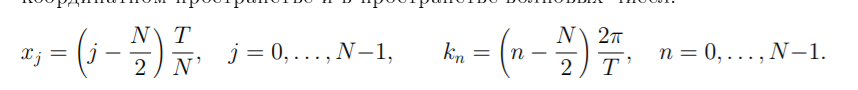

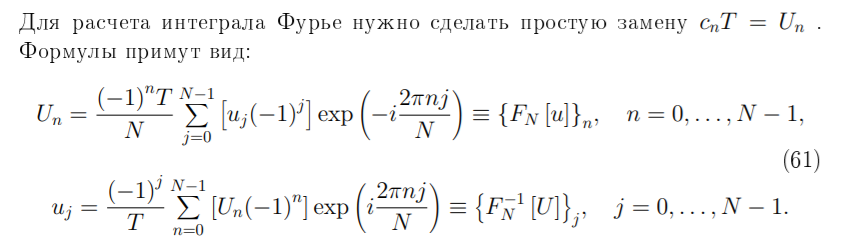

In [2]:
def myft(u, l):
    N = u.shape[0]
    u = np.array([np.complex128(elem) for elem in u])
    u_ft = np.zeros(N, dtype = np.complex128)
    for n in range(N):
        exp_sum = np.array([(-1)**k * exp(-1j * 2 * pi * n * k / N) for k in range(N)])
        u_ft[n] =(-1)**n * l/N * np.sum(u * exp_sum)
    return u_ft

def myift(u, l):
    N = u.shape[0]
    u = np.array([np.complex128(elem) for elem in u])
    u_ft = np.zeros(N, dtype = np.complex128)
    for n in range(N):
        exp_sum = np.array([(-1)**k * exp(1j * 2 * pi * n * k / N) for k in range(N)])
        u_ft[n] =(-1)**n /l * np.sum(u * exp_sum)
    return u_ft

8.1601392309949e-15


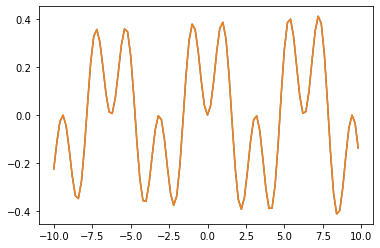

In [127]:
u = np.array([exp(y/100) * cos(y) * (sin(y)) ** 2 for y in x])
u_ft = myft(u, l)
u1 = myift(u_ft, l).real
plt.plot(x, u)
plt.plot(x, u1)
print(max(np.abs(u - u1)))

In [122]:
from scipy.fft import fft, ifft
u_ft1= fft(u)
u2 = ifft(u_ft1)
max(np.abs(u2 - u))

2.228461708575076e-16

In [142]:
def next_layer(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    u3 = np.array([u2[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    return u3

def next_layer1(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    return u2

def f(x):
    c = [1]
#     return hermval(x, c)
    return exp(-x**2/2)

def V(x):
    return x**2/2

def initialize(x):
    phi = np.array([f(x0) for x0 in x])
    vd = np.array([V(x0) for x0 in x])
    v = phi.copy()
    errors = []
    return phi, vd, v, errors

u, vd, v, errors = initialize(x)
fig, ax = plt.subplots(figsize = (12, 7))
ax.grid(True)
ln1, = plt.plot([], [], color = 'b', linestyle = 'dotted', label = "Действительная часть")
ln2, = plt.plot([], [], color = 'brown', linestyle = 'dotted', label = "Мнимая часть")
ln3, = plt.plot([], [], color = 'darkmagenta', linestyle = 'dotted', label = "Модуль")
ln4, = plt.plot([], [], color = 'r', linestyle = 'dashed', label = "Мнимая часть точная")
ln5, = plt.plot([], [], color = 'c', linestyle = 'dashed', label = "Действительная часть точная")
ln6, = plt.plot([], [], color = 'm', linestyle = 'dashed', label = "Модуль точный")

def precise_solution(nt):
    return exp(-1j * nt*tau/2) * exp(-x**2/2)


def init():
    ax.set_xlim(-l/2, l/2)
    ax.set_ylim(-1.2, 1.2)
    ax.legend()
    return ln1,

def update(nt):
    global u, vd, v, errors
    ln1.set_data(x, real(u))
    ln2.set_data(x, imag(u))    
    ln3.set_data(x, abs(u))
    ln4.set_data(x, imag(v))
    ln5.set_data(x, real(v))
    ln6.set_data(x, abs(v))
    errors.append(np.max(np.abs(u - v)))
    u = next_layer(u, x, l, vd, tau, k)
    v = precise_solution(nt + 1)
    return ln1,


anim = FuncAnimation(fig, update, frames=tqdm_notebook(range(Nt)), init_func = init, interval = 100, blit=True)
html5video = anim.to_html5_video()
plt.close()
HTML(html5video)
 
    

In [140]:
errors2Nt = errors.copy()
errors2Nt = errors2Nt[::2] 

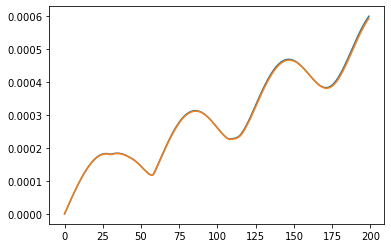

In [144]:
plt.figure()
plt.plot(range(Nt), errors)
plt.plot(range(Nt), 4*np.array(errors2Nt))

In [6]:
def next_layer(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    u3 = np.array([u2[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    return u3

def next_layer1(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    return u2

def initialize(f, V, x):
    phi = np.array([f(x0) for x0 in x])
    vd = np.array([V(x0) for x0 in x])
    v = phi.copy()
    errors = []
    return phi, vd, v, errors

def animation(initial, potential, precise_sol, l, Nx, Nt, T):
    global u, vd, v, errors
    x = np.array([(j - Nx/2) * l/Nx for j in range(Nx)])
    k = np.array([(j - Nx/2) * 2 * pi/l for j in range(Nx)])
    h = x[1] - x[0]
    tau = T/(Nt - 1)
    
    def initialize(x):
        u = np.array([initial(x0) for x0 in x])
        vd = np.array([potential(x0) for x0 in x])
        v = u.copy()
        errors = []
        return u, vd, v, errors
    
    u, vd, v, errors = initialize(x)
    fig, ax = plt.subplots(figsize = (12, 7))
    ax.grid(True)
    ln1, = plt.plot([], [], color = 'b', linestyle = 'dotted', label = "Действительная часть")
    ln2, = plt.plot([], [], color = 'brown', linestyle = 'dotted', label = "Мнимая часть")
    ln3, = plt.plot([], [], color = 'darkmagenta', linestyle = 'dotted', label = "Модуль")
    ln4, = plt.plot([], [], color = 'r', linestyle = 'dashed', label = "Мнимая часть точная")
    ln5, = plt.plot([], [], color = 'c', linestyle = 'dashed', label = "Действительная часть точная")
    ln6, = plt.plot([], [], color = 'm', linestyle = 'dashed', label = "Модуль точный")
    
    def init():
        ax.set_xlim(-l/2, l/2)
        ax.set_ylim(-1.2, 1.2)
        ax.legend()
        return ln1,

    def update(nt):
        global u, vd, v, errors
        ln1.set_data(x, real(u))
        ln2.set_data(x, imag(u))    
        ln3.set_data(x, abs(u))
        ln4.set_data(x, imag(v))
        ln5.set_data(x, real(v))
        ln6.set_data(x, abs(v))
        errors.append(np.max(np.abs(u - v)))
        u = next_layer(u, x, l, vd, tau, k)
        v = precise_sol([(nt + 1) * tau, x])
        return ln1,
    
    anim = FuncAnimation(fig, update, frames=tqdm_notebook(range(Nt)), init_func = init, interval = 100, blit=True)
    html5video = anim.to_html5_video()
    plt.close()
    return html5video

In [8]:
html5video = animation(initial = lambda x: exp(-x**2/2), potential = lambda x: x**2/2, precise_sol = lambda x: exp(-1j * x[0]/2) * exp(-x[1]**2/2), 
                       l = 20, Nx = 100, Nt = 100, T = 10)
HTML(html5video)